# Object Detection


In [332]:
#imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import cv2
# from cv2 import imshow as cv2_imshow
# from google.colab.patches import cv2_imshow
import tensorflow_hub as hub

import matplotlib.pyplot as plt
# import tempfile
# from six import BytesIO

import numpy as np
from PIL import Image
# from PIL import ImageColor
from PIL import ImageDraw
# from PIL import ImageFont
# from PIL import ImageOps

import time


import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
# from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TerminateOnNaN
from tensorflow.keras.optimizers import Adam,SGD
# from tensorflow.keras.regularizers import l2
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects


# from tensorflow import keras
# from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
# import os
# import random
# import collections
# from collections import defaultdict

# from shutil import copy
# from shutil import copytree, rmtree

import pandas as pd
from pathlib import Path
import os.path
# import shutil

# import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# from tensorflow.keras import layers

# from skimage import io #imread_collection
# from skimage import data, img_as_float
# from skimage import exposure
# from skimage.transform import rescale, resize
# from skimage.color import rgb2gray 
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import seaborn as sns

# Loading Dataset

In [320]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def proc_img(filepath):
  # assign a label for each pic ==> label
  # labels = [str(filepath[i]).split("/")[-2] \ # for Cloud (remove this comment if you want to use it)
  labels = [str(filepath[i]).split("\\")[-2]\
    for i in range(len(filepath))] # windows path
  filepath = pd.Series(filepath, name='Filepath',dtype='str')
  labels = pd.Series(labels, name='Label',dtype='str')

  df = pd.concat([filepath, labels], axis=1)
  df = df.sample(frac=1).reset_index(drop = True)
  
  return df


def display_image(image):
  plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !unzip drive/MyDrive/Food_Classification/teest.zip
# !unzip drive/MyDrive/Food_Classification/traain.zip

#List containing data paths
# data_dir = Path('drive/MyDrive/Food_Classification/Data')
data_dir = Path('Data')
data_filepaths = list(data_dir.glob(r'**/*.jpg'))
data_df = proc_img(data_filepaths)

## Sample Images from dataset

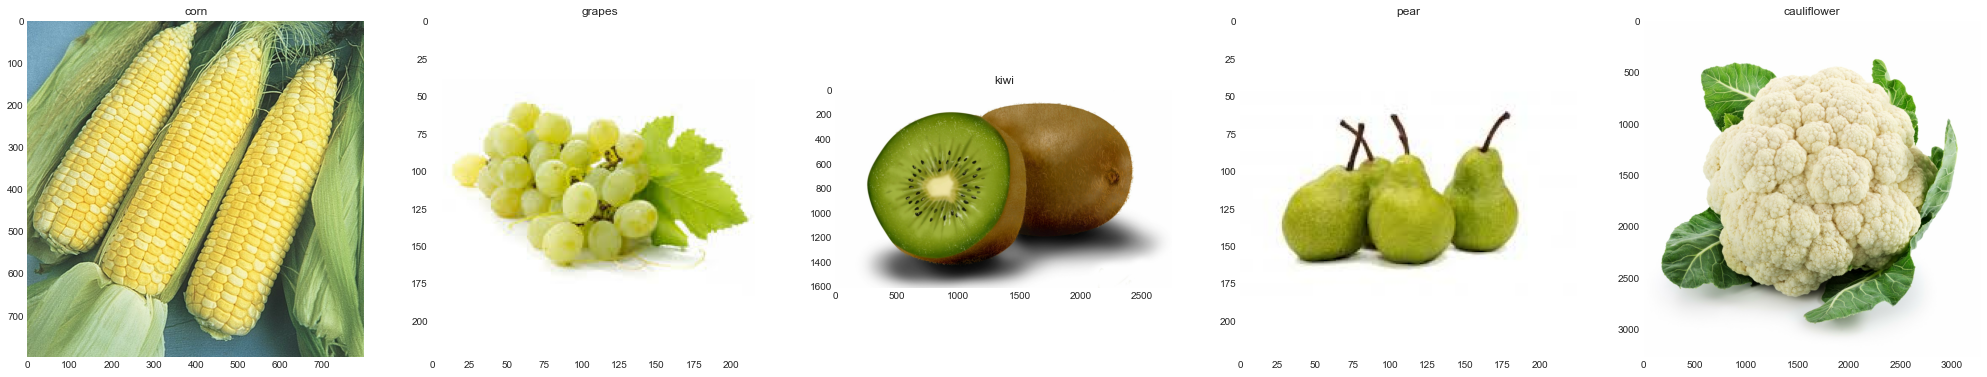

In [336]:
sample_img = data_df.sample(n=5)
plt.figure(figsize=(35,8))

for i, image in enumerate(sample_img.values):
    plt.subplot(int("15{}".format(i+1)))
    plt.grid(False)
    plt.title(image[1])
    plt.imshow(load_img(image[0]))

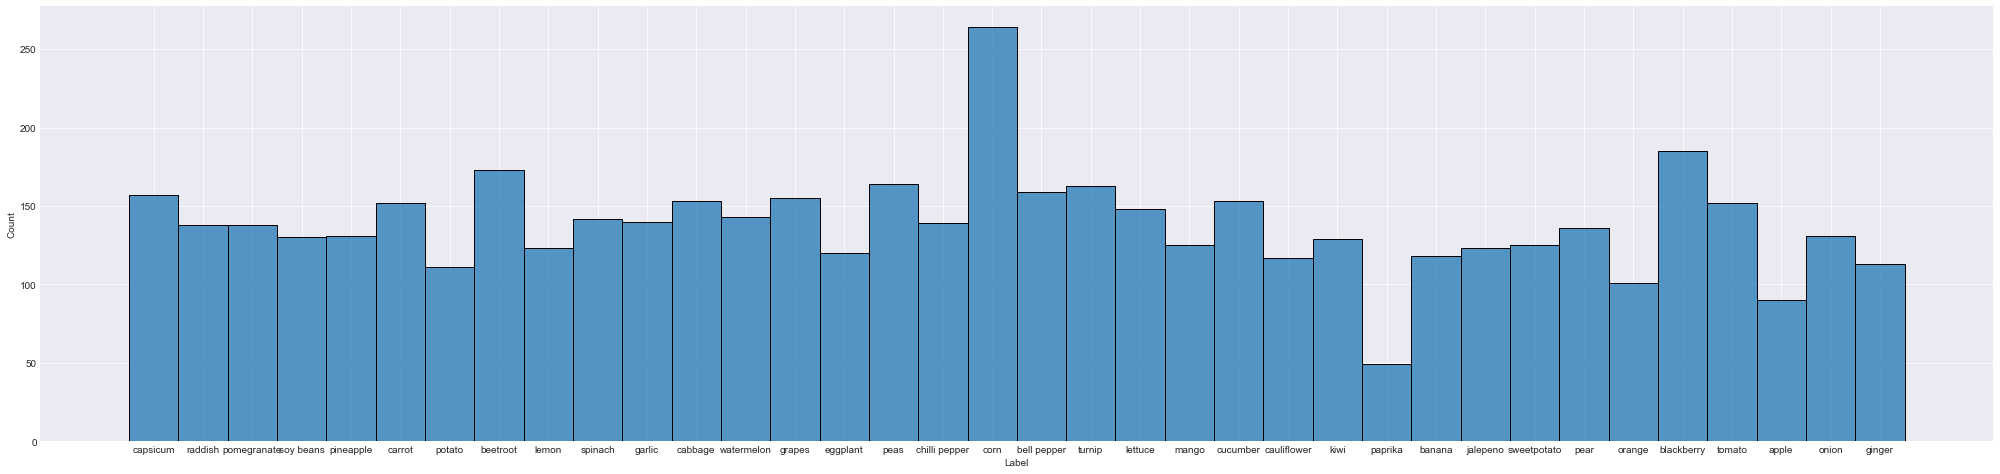

In [335]:
# count = data_df.Label.values_count()
plt.figure(figsize=(35,8))
sns.histplot(data_df.Label)
plt.show()

# Preprocessing

For the preprocessing, we used the Keras predefined function preprocess_input which will scale input pixels between -1 and 1

In [ ]:
img_width, img_height = 224, 224
batch_size = 16

train_df, test_df = train_test_split(data_df, test_size=.2, random_state=123)
# print("Train shape: ", train_df.shape, " | Test shape: ", test_df.shape)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

#################### loading training/testing images ###########################
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(img_width, img_height),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=0,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(img_width, img_height),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

## Data Augmentation

For this part, we also used the keras function ImageDataGenerator in order to augment our dataset (in order to double its in size)

Found 3246 validated image filenames belonging to 30 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


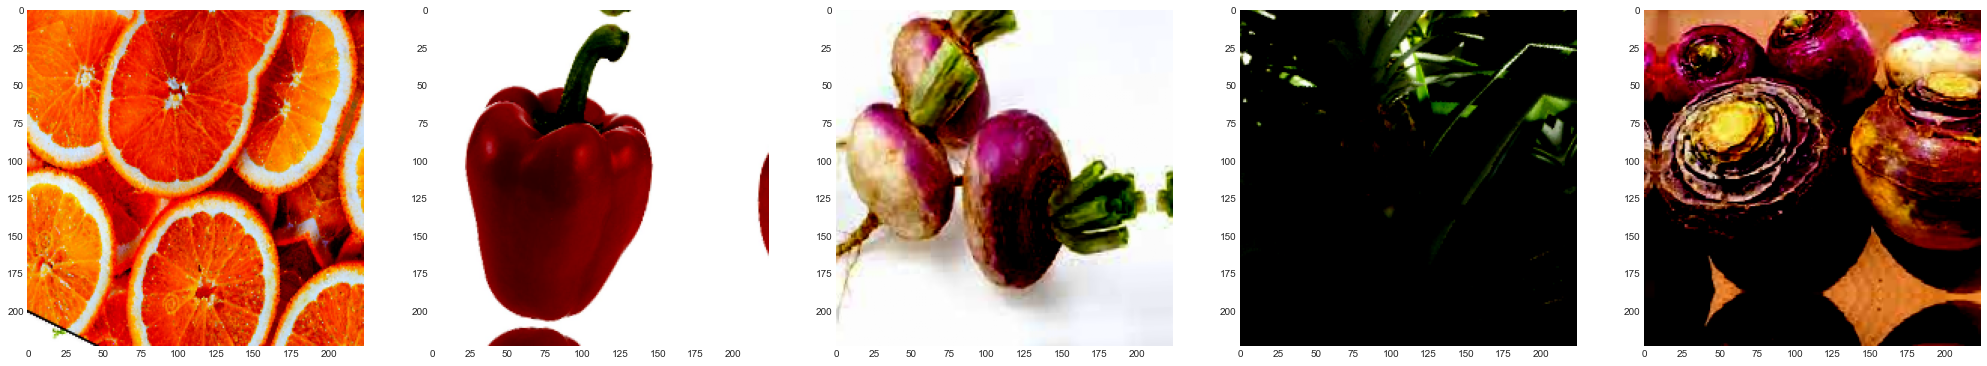

In [380]:
train_generator_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="reflect"
    )

train_images_augmented = train_generator_aug.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(img_width, img_height),
    seed=0,
    shuffle=True,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size
)

rand_idx = list(zip(np.random.randint(0, int(len(train_df)/16), 5), np.random.randint(0, 16, 5)))

plt.figure(figsize=(35,8))
i=0
for idx1, idx2 in rand_idx:
    plt.subplot(int("15{}".format(i+1)))
    plt.grid(False)
    plt.imshow(train_images_augmented[idx1][0][idx2])
    
    i+=1

# Food classification

## Base Model Training

The results of the base model are meant to be used as a comparison for when we implement the new loss function (ii-loss).

In [ ]:
def train_model2(train_df, n_classes, num_epochs, batch_size, optimizer_func, activation_func, test_df=None, retrain=False, model=None, base_model=True):
  K.clear_session()
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  
  ############################################################################
  ######################### Fine tuning part #################################
  """retrain=True means that we want to retain a previous model for a few more
  epochs in order to achive better accuracy"""

  if not retrain: 
    # Pre trained model on imagenet==> works good with mobiles
    pretrained_model = tf.keras.applications.MobileNetV2(
        input_shape=(img_width, img_height, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    pretrained_model.trainable = False
    inputs = pretrained_model.input

    if base_model:
      x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
      x = Dropout(0.2)(x)
      x = tf.keras.layers.Dense(128, activation='relu')(x)

      outputs = tf.keras.layers.Dense(n_classes, activation=activation_func)(x)
      model = tf.keras.Model(inputs=inputs, outputs=outputs)
      model.compile(optimizer=optimizer_func,loss='categorical_crossentropy',metrics=['accuracy'])
    
    else:
      x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer="l2")(pretrained_model.output)
      x = Dropout(0.2)(x)
      x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer="l2")(x)

      outputs = tf.keras.layers.Dense(n_classes, activation=activation_func)(x)
      model = tf.keras.Model(inputs=inputs, outputs=outputs)
      model.compile(
        optimizer=Adam(learning_rate=.0001, epsilon=1e-09, clipnorm=1., clipvalue=1.), #beta_1=0.5, beta_2=0.999),
        loss=ii_loss,
        metrics=[newAcc], run_eagerly=True)  # ii-loss implementation

  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True) #for saving the best model
  
  if test_df is not None:
    history = model.fit(
        train_images,
        batch_size = batch_size,
        epochs=num_epochs,
        validation_data=test_images,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='loss',
                patience=2,
                restore_best_weights=True),
            checkpoint,
            TerminateOnNaN()
        ]
    )
  else:
    history = model.fit(
        train_images,
        batch_size = batch_size,
        epochs=num_epochs,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='loss',
                patience=2,
                restore_best_weights=True),
            checkpoint,
            TerminateOnNaN()
        ]
    )
    
  return history

In [33]:
epochs = 6
n_classes = len(train_df.Label.unique())
food_list = np.sort(train_df.Label.unique())

class_means = tf.keras.utils.to_categorical(LabelEncoder().fit_transform(food_list.reshape(-1, 1)).reshape(-1, 1))
evaluation, train_iter, val_iter = False, 0, 0
train_size = len(train_df)
val_size = len(test_df)
batch_size = 16

# print(n_classes)
with tf.device("/GPU:0"):
    history = train_model2(train_df, n_classes, epochs, batch_size, "rmsprop", "softmax", test_df=test_df)
    # history = train_model2(train_df, n_classes, epochs, batch_size, "adam", "softmax", test_df=test_df)


Found 3992 validated image filenames belonging to 36 classes.
Found 998 validated image filenames belonging to 36 classes.
Epoch 1/6
125/125 [==============================] - 79s 605ms/step - loss: 1.4325 - accuracy: 0.6162 - val_loss: 0.7079 - val_accuracy: 0.7926

Epoch 00001: val_loss improved from inf to 0.70786, saving model to bestmodel_36class.hdf5
Epoch 2/6
125/125 [==============================] - 74s 591ms/step - loss: 0.5546 - accuracy: 0.8284 - val_loss: 0.6800 - val_accuracy: 0.8016

Epoch 00002: val_loss improved from 0.70786 to 0.68003, saving model to bestmodel_36class.hdf5
Epoch 3/6
125/125 [==============================] - 70s 559ms/step - loss: 0.3273 - accuracy: 0.9021 - val_loss: 0.6656 - val_accuracy: 0.8036

Epoch 00003: val_loss improved from 0.68003 to 0.66560, saving model to bestmodel_36class.hdf5
Epoch 4/6
125/125 [==============================] - 66s 526ms/step - loss: 0.2174 - accuracy: 0.9281 - val_loss: 0.6027 - val_accuracy: 0.8377

Epoch 00004: val

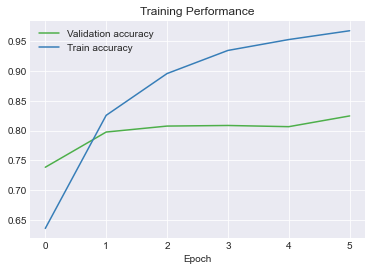

In [24]:
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.plot(history.history["val_accuracy"], label='Validation accuracy', color = palette(2))
plt.plot(history.history["accuracy"], label='Train accuracy', color = palette(1))
plt.title("Base Model Training Performance")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## ii-loss implemnetation

In [204]:
def ii_loss(y_true, y_pred):
    global class_means, evaluation, train_iter, val_iter, train_size, val_size, noise

    y_true_ = K.argmax(y_true, axis=-1)    # Class Labels of each instance (1, 2,.., n)
    y_true_unique = np.unique(y_true_)  # Unique classes
    # intra-spread
    intra_spread = tf.divide(
        K.sum(
            K.map_fn(
                lambda C: K.sum(
                    K.pow(
                        class_means[C] - y_pred[K.equal(y_true_, C)],
                        2)),
                y_true_unique,
                dtype=tf.float32)),
        len(y_pred))

    # inter-separation
    inter_separation = tf.Variable(-1.0)
    for index1 in range(len(class_means)):
        mean1 = class_means[index1]
        for mean2 in class_means[index1+1:]:
            int_sep = K.sum(tf.pow(tf.subtract(mean2, mean1), 2))
            if inter_separation < 0 or inter_separation > int_sep:
                inter_separation = int_sep
    
    # loss
    loss = tf.divide(-1, tf.subtract(intra_spread, inter_separation))
  
    # Evaluation: case of Validation/Test
    # Train_iter/val_iter help keep track of which phase of the training the algorithm is processing
    if not evaluation and train_iter <= int(train_size/batch_size): #case training
        class_means = K.map_fn(
            lambda C: K.mean( y_pred[ K.equal(y_true_, C) ], axis=0),
            y_true_unique,
            dtype=tf.float32).numpy()
        train_iter +=1
    elif evaluation:
      pass
    # case validation
    elif val_iter <= int(val_size/batch_size):
        evaluation = True
        val_iter +=1
    # case done with validation, so we reset the variables
    else:
        evaluation = False
        train_iter = 0
        val_iter = 0
        if noise:
            class_means = tf.keras.utils.to_categorical(LabelEncoder().fit_transform(food_list.reshape(-1, 1)).reshape(-1, 1))[:n_classes-6,:n_classes-6] # reset class_means
        else:
            class_means = tf.keras.utils.to_categorical(LabelEncoder().fit_transform(food_list.reshape(-1, 1)).reshape(-1, 1)) # reset class_means
    return loss

def newSoftmax(y_pred):
    global class_means
    
    # Implemenration Using Tensorflow
    if y_pred.shape[0] != None:
        logits = K.map_fn(lambda proj:\
            K.map_fn(lambda C: K.exp(-K.sum(K.pow(tf.subtract(C, proj), 2))), class_means),
            y_pred)
        
        logits = K.map_fn(lambda expDenom:\
            K.map_fn(lambda num: num/K.sum(expDenom), expDenom)
            , logits)

        return logits

def newAcc(y_true, y_pred):
    correct_predictions = tf.equal(tf.argmax(y_true, axis=1), tf.argmax(y_pred, axis=1))
    acc = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return acc

# Registed the new Activation function to keras objects
get_custom_objects().update({'newSoftmax': Activation(newSoftmax)})

### Training w/o Noise

First, we will train a model using only ii-loss as a loss function, without creating adding noise/outliers to the training set.

In [ ]:
batch_size = 16
noise = False
class_means = tf.keras.utils.to_categorical(LabelEncoder().fit_transform(food_list.reshape(-1, 1)).reshape(-1, 1))
with tf.device("/GPU:0"):
    history_iiloss = train_model2(train_df, n_classes, epochs, batch_size, "/", "newSoftmax", test_df=test_df, base_model=False)

Next, we shall create noise in the training set by selecting 30 classes as known, and dispatching 1% of the training set size of the remaining classes around the known classes.

This is meant to help fine-tune the *Outlier Threshold*.

NB: The previous percentage (1%) is called the `Contamination Ratio`

In [200]:
def createNoise(data_df, ratio=0.01):
    # ratio: contamination ratio
    labels = data_df.Label.unique() # Get Unique food labels
    unknown_idx = np.random.randint(0, n_classes, 6) # random indexes of classes to turn into noise
    data_df = data_df.replace(data_df.Label.unique()[unknown_idx],"unknown") # replace the labels of the chosen classes with "unknown"
    
    train_df, test_df = train_test_split(data_df, test_size=.2, random_state=34)
    train_unknown = train_df[train_df.Label == "unknown"]   # Noise
    train_unknown = train_unknown.sample(n=int(len(train_df)*ratio))    # Get 1% of the data and make it unknown
    
    # Select random class names for train_unknown (contaminate the data)
    class_idx = []
    while len(class_idx) < len(train_unknown):
        idx = np.random.randint(0, n_classes)
        if idx not in unknown_idx:
            class_idx.append(idx)        
    
    # replace classes
    new_labels = labels[class_idx]
    train_unknown.Label = new_labels
    
    train_df = train_df.drop(index = train_df[train_df.Label == "unknown"].index)   # drop unknown class from train_data
    train_df = pd.concat([train_df, train_unknown], axis=0) # contaminate data
    
    train_df = train_df.sample(frac=1).reset_index(drop=True)   # shuffle train_data
    return train_df, test_df

In [201]:
contamination_ratio = 0.01
train_df_new, test_df_new = createNoise(data_df, contamination_ratio)
train_df_new.shape, test_df_new.shape

((3246, 2), (998, 2))

### Training w/ Noise

Now we train another model using the ii-loss function

In [318]:
batch_size = 16
n_classes -= 6
class_means = tf.keras.utils.to_categorical(LabelEncoder().fit_transform(food_list.reshape(-1, 1)).reshape(-1, 1))[:n_classes,:n_classes]

with tf.device("/GPU:0"):
    history_iiloss_noisy = train_model2(train_df_new, n_classes, epochs, batch_size, "/", "newSoftmax", test_df=test_df_new[test_df_new.Label != "unknown"])

Found 3246 validated image filenames belonging to 30 classes.
Found 819 validated image filenames belonging to 30 classes.
Epoch 1/6
203/203 [==============================] - 694s 3s/step - loss: 3.9615 - newAcc: 0.1564 - val_loss: 3.3685 - val_newAcc: 0.3421

Epoch 00001: val_loss improved from inf to 3.36854, saving model to bestmodel_30class.hdf5
Epoch 2/6
203/203 [==============================] - 660s 3s/step - loss: 2.9649 - newAcc: 0.4275 - val_loss: 2.5846 - val_newAcc: 0.5621

Epoch 00002: val_loss improved from 3.36854 to 2.58457, saving model to bestmodel_30class.hdf5
Epoch 3/6
203/203 [==============================] - 932s 5s/step - loss: 2.3278 - newAcc: 0.5827 - val_loss: 2.0737 - val_newAcc: 0.6667

Epoch 00003: val_loss improved from 2.58457 to 2.07370, saving model to bestmodel_30class.hdf5
Epoch 4/6
203/203 [==============================] - 730s 4s/step - loss: 1.9034 - newAcc: 0.6525 - val_loss: 1.7266 - val_newAcc: 0.7063

Epoch 00004: val_loss improved from 2.07

### Claculating the *Outlier Score* Threshhold

We calculating the class_means of the training set, then we compute the outlier_scores of the test set projections. Finally, we sort those score in descending, and chooses the 1%th value as the `Outlier Threshold.`

In [416]:
def computeClassMeans(y_pred, train_df):
    y_true = LabelEncoder().fit_transform(train_df.Label)
    y_trueUnique = np.unique(y_true)

    class_means = np.array(list(map(\
        lambda C: np.mean( y_pred[y_true == C], axis=0),
        y_trueUnique)))

    return class_means

# Compute the outlier score for given batch
def outlier_score(logits):
  global class_means
  scores = np.min(np.array(list(map(lambda proj: list(map(lambda class_mean: sum(pow(class_mean - proj, 2)) ,class_means)), logits))), axis=-1)
  
  return scores

# New activation function
def activationFunc(logits, y_true, threshhold, n_classes, unknown_idx):
  # threshhold: outlier_score threshhold

  outlier_scores =  outlier_score(logits)
  preds, outs, out = [], [], 0
  
  print("DEBUG: score", len(outlier_scores[outlier_scores > threshhold]))

  for index, score in enumerate(outlier_scores):
    if score >= threshhold:
      # print("%.5f >= %.5f" % (score, threshhold))
      preds.append(unknown_idx)
      outs.append(y_true[index])
      out+=1
    else:
      preds.append(np.argmax(logits[index], axis=-1))
  
  outs = np.array(outs)
  preds = np.array(preds)
  return preds, outs, out, outlier_scores

In [390]:
train_generator_new = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_images_new = train_generator_new.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(img_width, img_height),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

train_y_pred = history_iiloss_noisy.model.predict(train_images_new)

#1# Compute Class Means
class_means = computeClassMeans(train_y_pred, train_df)

#2# calculate outlier_score for each projection
train_outlier_scores = outlier_score(train_y_pred)

#3# sort scores in descending
#4# filter the top 1% (contamination ratio) and determine Outlier Threshold
threshold = np.sort(train_outlier_scores, axis=0)[::-1][:int(train_outlier_scores.shape[0]*contamination_ratio)][-1]

print("Outlier Threshold = ", threshold)

Found 3246 validated image filenames belonging to 30 classes.


C:\Users\pc\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
C:\Users\pc\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Outlier Threshold =  0.17811639131218726


`Outlier Threshold = 0.17811639131218726`

## Testing

In [417]:
test_images_new = test_generator.flow_from_dataframe(
    # dataframe=test_df[test_df.Label != "unknown"],
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(img_width, img_height),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)
encoder = LabelEncoder()
test_logits = history_iiloss_noisy.model.predict(test_images_new)
test_y_true = encoder.fit_transform(test_df.Label)
# test_y_true = LabelEncoder().fit_transform(test_df[test_df.Label!="unknown"].Label)
unknown_idx = encoder.inverse_transform(np.unique(test_y_true)).tolist().index("unknown")

preds, outs, out, outlier_scores = activationFunc(test_logits, test_y_true, threshold, n_classes, unknown_idx)
print("Accuracy = ", accuracy_score(test_y_true, preds), " | Uknown Detected = ", out)
print("True unknown ratio = {}".format(len(outs[outs==unknown_idx])/len(test_y_true[test_y_true==unknown_idx])))

Found 998 validated image filenames belonging to 31 classes.
DEBUG: score 2
Accuracy =  0.5841683366733467  | Uknown Detected =  2
True unknown ratio = 0.0


In [412]:
# len(test_y_true[test_y_true==29]), len(test_df[test_df.Label == "unknown"])
# encoder = LabelEncoder()
test_y_true = encoder.fit_transform(test_df.Label)
print(np.unique(test_y_true))
print(encoder.inverse_transform(np.unique(test_y_true)))
# print("True unknown ratio = {}".format(len(outs[outs==29])/len(test_y_true[test_y_true==29])))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
['apple' 'beetroot' 'bell pepper' 'blackberry' 'cabbage' 'capsicum'
 'carrot' 'cauliflower' 'chilli pepper' 'eggplant' 'garlic' 'ginger'
 'grapes' 'jalepeno' 'kiwi' 'lettuce' 'mango' 'onion' 'orange' 'paprika'
 'pear' 'pineapple' 'pomegranate' 'potato' 'raddish' 'soy beans'
 'sweetpotato' 'tomato' 'turnip' 'unknown' 'watermelon']


In [423]:
len(test_y_true[test_y_true==unknown_idx])
# np.sort(outlier_scores, axis=0)[::-1]
# outlier_scores[outlier_scores > threshhold]
np.sort(outlier_scores, axis=0)[::-1]

# outlier_scores_train = outlier_score(train_y_pred)
# np.sort(outlier_scores_train, axis=0)[::-1][:50]


179

# Real Life Test
We used a pre-trained model capable of detecting 600 classes of different 

As an already trained model on the OpenImage v4 database, it is capable of detecting 600 different classes.

We adapted the detector to our needs, so we limited it to only detect food.


In [ ]:
#Filter the 600 classes
food = ['Food','Apple','Beer','Croissant','Cucumber','Hot dog','Fast food','Waffle','Pancake','Bagel','Popcorn','Burrito','Toaster','Cheese','Juice',
        'Cookie','Cocktail','Dessert','Zucchini','Drink','Coffee','Fruit','French fries','Tart','Egg','Grape','Bottle','Milk','Potato','Pasta',
        'Pumpkin','Pear','Pizza','Seafood','Sushi','Tea','Tomato','Bread','Chicken','Banana','Hamburger','Ice cream','Orange','Peach','Vegetable',
        'Carrot','Mango','Cake','Broccoli','Grapefruit','Shrimp']

inception_resnet_v2 is a pre trained model for object detection, on Open Images dataset V4 (600 classes)

In [ ]:
# module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"  # load from URL
module_handle = "1" # load from local folder
detector = hub.load(module_handle).signatures['default']

In [424]:
def crop(path,image,ymin,xmin,ymax,xmax,id,thickness=4):
  idx = id

  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)


  img = cv2.imread(path)
  crop_img = img[int(top):int(bottom), int(left):int(right)]
  cv2.imwrite("final/did_it_"+str(idx) + '.jpg', crop_img)

  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),(left, top)], width=thickness)

def draw_boxes(path,image, boxes, class_names, scores, max_boxes=20, treshold=0.05):
  idx =0
  for i in range(min(boxes.shape[0], max_boxes)):
    
    if scores[i] >= treshold:
      #print(class_names[i].decode("ascii"))
      # draw a box if the food detected is part of the class_names filtered (originally, there exists 600 classes)
      if (class_names[i].decode("ascii") in food):
        ymin, xmin, ymax, xmax = tuple(boxes[i])
        #print(ymin)

        image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
        idx +=1
        crop(path,image_pil,ymin,xmin,ymax,xmax,idx)
        np.copyto(image, np.array(image_pil))

  return image

def detection(path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  result = detector(converted_img)

  result = {key:value.numpy() for key,value in result.items()}

  image_with_boxes = draw_boxes(path,
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

  # return image

In [438]:
from keras_preprocessing import image

def predict_class(images, history, show=True):
  preds,images_ar=[],[]

  #Normal prediction
  for img in images:
    img = image.load_img(img, target_size=(224, 224,3))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)   
   
    pred = history.model.predict(img)
    index = np.argmax(pred,axis=1)[0]
    # print(index)
    # print("HERE")
    try:
      pred_value = food_list[index]
    except Exception as e:
      if e == "IndexError":
        pred_value = "unknown"
        
    preds.append(pred_value)
    images_ar.append(img[0])
    

  return images_ar, preds

In [ ]:
# Creating a folder for cropped images
os.mkdir('final_test_results')

## Segmentation and Detection

In [ ]:
detection('final_test/a.jpg')

### Loading The Images of The Detected Food

In [430]:
finalTest_dir = Path('final_test_results')
finalTest_filepaths = list(finalTest_dir.glob(r'**/*.jpg'))

labels = [str(finalTest_filepaths[i]).split("\\")[-2]\
        for i in range(len(finalTest_filepaths))] # windows path
filepath = pd.Series(finalTest_filepaths, name='Filepath',dtype='str')
labels = pd.Series(labels, name='Label',dtype='str')

finalT = pd.concat([filepath, labels], axis=1)
finalT = finalT.sample(frac=1).reset_index(drop = True)
finalT.shape

(30, 2)

### Predicting Classes of The Detected Food

In [439]:
images, preds = predict_class(finalT.Filepath, history_iiloss_noisy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


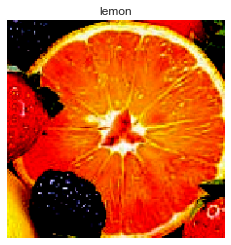

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


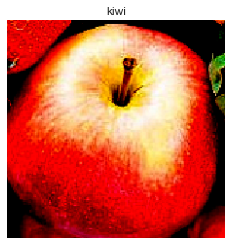

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


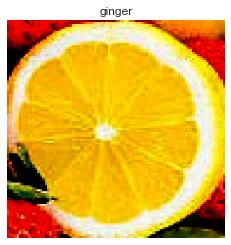

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


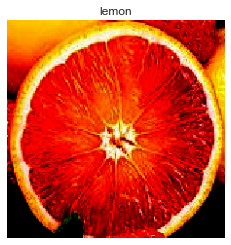

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


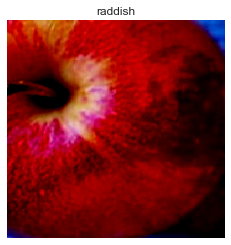

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


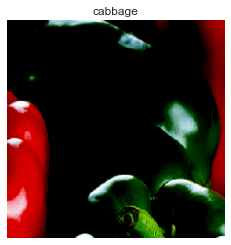

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


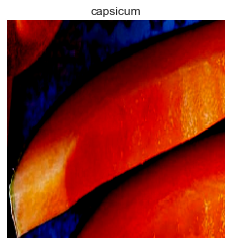

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


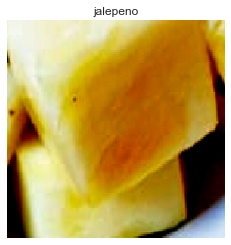

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


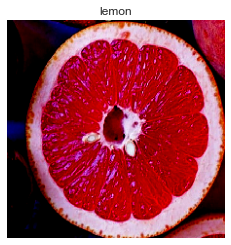

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


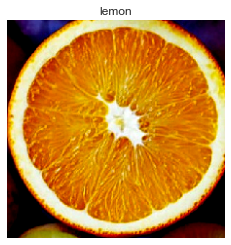

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


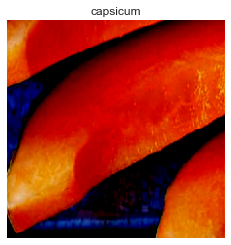

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


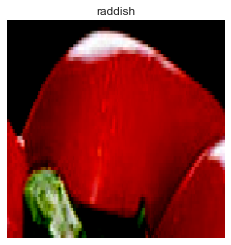

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


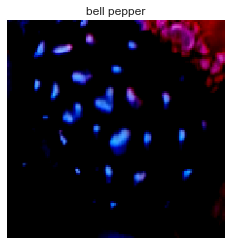

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


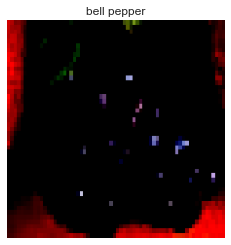

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


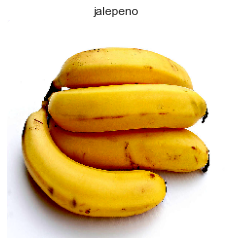

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


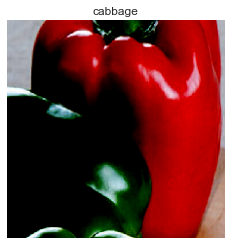

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


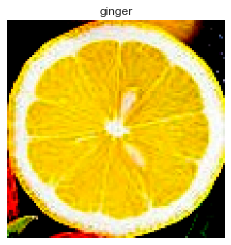

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


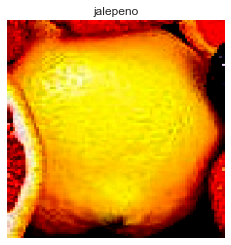

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


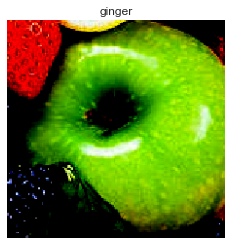

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


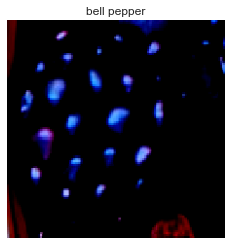

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


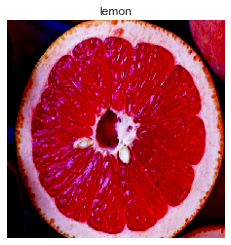

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


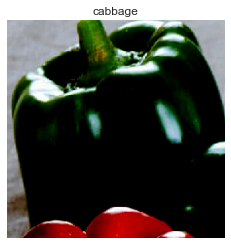

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


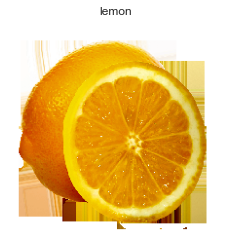

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


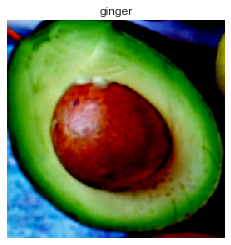

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


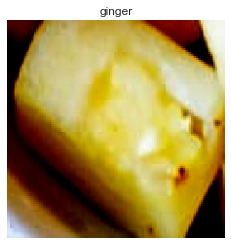

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


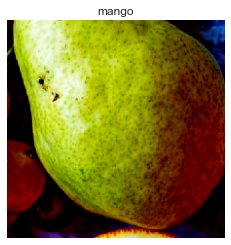

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


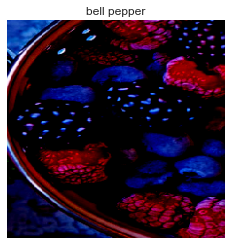

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


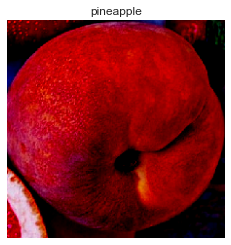

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


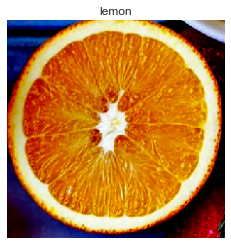

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


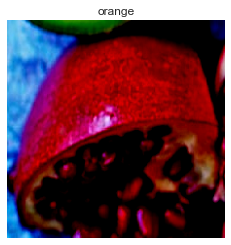

In [446]:
for index, image in enumerate(images):
    plt.imshow(image)                           
    plt.axis('off')
    plt.title(preds[index])
    plt.show()